In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Dynamical methods

Below we show some methods to solve equations of motion of dynamical systems. These are symplectic methods and hence respects energy conservation for long-time simulations.

$\Large {\text{Verlet:} 
\qquad\qquad\qquad\;\;\begin{aligned}[t]
y_{n+1} = 2y_n - y_{n-1} + a_n h^2
\end{aligned}
}$

$\Large {\text{Velocity Verlet:} 
\quad\begin{aligned}[t]
y_{n+1} &= y_n + v_n h + a_n h^2/2 \\
v_{n+1} &= v_n + h (a_n + a_{n+1})/2
\end{aligned}
}$

$\Large {\text{Leapfrog:} 
\qquad\qquad\begin{aligned}[t]
v_{n+1/2} &= v_n + h a_n/2 \\
y_{n+1} &= y_n + h v_{n+1/2} \\
v_{n+1} &= v_{n+1/2} + h a_{n+1}/2
\end{aligned}
}$

In [10]:
import numpy as np

def verlet(f1, x, yn, ynm1, h):
    return 2*yn - ynm1 + f1(x, yn)*(h**2)


def velocity_verlet(f1, x, yn, vn, h):
    ynp1 = yn + vn*h + 0.5*f1(x, yn)*(h**2)
    vnp1 = vn + 0.5*(f1(x, yn) + f1(x + h, ynp1))*h
    return ynp1, vnp1

def leapfrog(f1, x, yn, vn, h):
    vnph = vn + 0.5*f1(x, yn)*h
    ynp1 = yn + vnph*h
    vnp1 = vnph + 0.5*f1(x + h, ynp1)*h
    return ynp1, vnp1

def caller_y(method, fn, y0, v0, N, xs, h):
    ys = np.zeros(N)
    
    ys[0] = y0
    
    # We assume x0 is xs[0], if not specified otherwise.
    x0 = xs[0]
    
    # Often this is given.
    ys[1] = y0 + v0*h + 0.5*fn(x0, y0)*(h**2)

    # Loop starts 
    for i in range(2, N):
        x = xs[i]
        ys[i] = method(fn, x, ys[i-1], ys[i-2], h)
    
    return ys


def caller_yv(method, fn, y0, v0, N, xs, h):
    """
    Uses a position-velocity integrator (like Velocity Verlet or Leapfrog).
    method is typically `velocity_verlet` or `leapfrog`, 
    but can be another function with signature: method(fn, x, y, v, h).
    
    Returns arrays of positions (ys) and velocities (vs).
    """
    ys = np.zeros(N)
    vs = np.zeros(N)
    
    ys[0] = y0
    vs[0] = v0

    # In Julia, loop was 2:N. In Python, that's range(1, N).
    for i in range(1, N):
        x = xs[i]
        ys[i], vs[i] = method(fn, x, ys[i-1], vs[i-1], h)
    
    return ys, vs




In [11]:
import numpy as np

# Define the function g(x, y) = -y
def g(x, y):
    return -y

# Step size and initial x-value
h = 1.0e-2
x0 = 0.0

# Number of steps
N = 5001

# Generate the array of x-values, equivalent to Julia's range(x0, step=h, length=N)
xs = np.arange(N) * h + x0   # [x0, x0+h, x0+2h, ..., x0+(N-1)*h]

# Initial conditions
y0 = 1.0
v0 = 0.0

# Compute y-values using position-only Verlet
ysV = caller_y(verlet, g, y0, v0, N, xs, h)

# Compute y and v values using Velocity Verlet
ysVV, vsVV = caller_yv(velocity_verlet, g, y0, v0, N, xs, h)

# Compute y and v values using Leapfrog
ysL, vsL = caller_yv(leapfrog, g, y0, v0, N, xs, h)



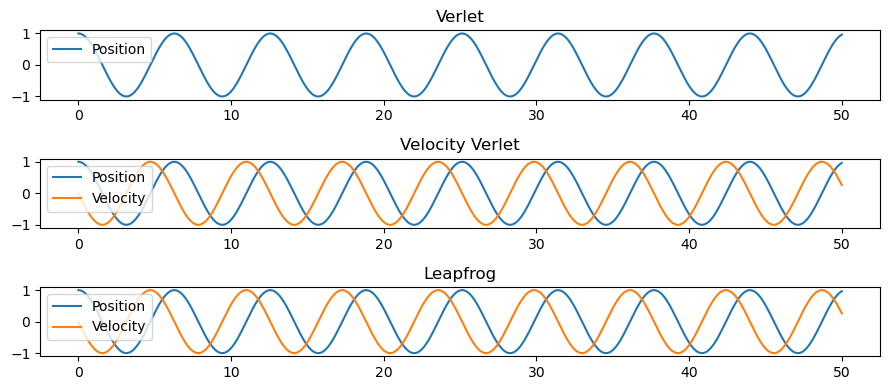

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4))  # (width=9, height=4) in inches

# 1) Verlet
axes[0].plot(xs, ysV, label='Position')
axes[0].set_title('Verlet')
axes[0].legend()

# 2) Velocity Verlet
axes[1].plot(xs, ysVV, label='Position')
axes[1].plot(xs, vsVV, label='Velocity')
axes[1].set_title('Velocity Verlet')
axes[1].legend()

# 3) Leapfrog
axes[2].plot(xs, ysL, label='Position')
axes[2].plot(xs, vsL, label='Velocity')
axes[2].set_title('Leapfrog')
axes[2].legend()

plt.tight_layout()
plt.show()


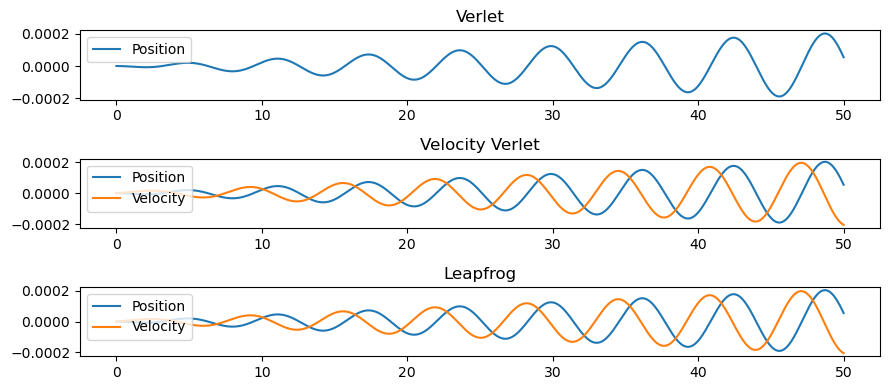

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4))  # similar to size=(900,400) in Julia

# 1) Verlet
axes[0].plot(xs, ysV - np.cos(xs), label="Position")
axes[0].set_title("Verlet")
axes[0].legend(loc="upper left")  # 'upper left' ~ ':topleft' in Julia

# 2) Velocity Verlet
axes[1].plot(xs, ysVV - np.cos(xs), label="Position")
axes[1].plot(xs, vsVV + np.sin(xs), label="Velocity")
axes[1].set_title("Velocity Verlet")
axes[1].legend(loc="upper left")

# 3) Leapfrog
axes[2].plot(xs, ysL - np.cos(xs), label="Position")
axes[2].plot(xs, vsL + np.sin(xs), label="Velocity")
axes[2].set_title("Leapfrog")
axes[2].legend(loc="upper left")

plt.tight_layout()
plt.show()


## Symplectic methods: Verlet, velocity Verlet, Leapfrog

### With Euler
$$
H_{\mathrm{new}} - H_{\mathrm{old}}
= \tfrac12\,(\Delta t)^2
\,\bigl[\omega^4\,x_{\mathrm{old}}^2 + \omega^2\,p_{\mathrm{old}}^2\bigr]
\;\ge\;0.
$$

### With leapfrog
$$
  H_{\mathrm{new}} - H_{\mathrm{old}}
  \;=\;\tfrac14\,\omega^4\,x_{\mathrm{old}}\,p_{\mathrm{old}}
  \,(\Delta t)^3
  \;+\;\mathcal{O}\bigl((\Delta t)^4\bigr).
$$